## Colab & Drive環境設定

### Drive連結

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 切換路徑



```
#git clone https://github.com/chungyilin-gn/STGAT.git
#cd drive/My Drive/PhD/程式/TrajectoryPrediction/STGAT  
```



In [7]:
cd drive/My Drive/PhD/程式/TrajectoryPrediction/STGAT

/content/drive/My Drive/PhD/程式/TrajectoryPrediction/STGAT


## 主程式

### Library

In [16]:
import argparse
import logging
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Model.py #
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

# Main.py
import easydict
import time

### Utils

In [12]:
import os
import logging
import torch

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print("\t".join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = "{:" + str(num_digits) + "d}"
        return "[" + fmt + "/" + fmt.format(num_batches) + "]"


def set_logger(log_path):
    """Set the logger to log info in terminal and file `log_path`.
    In general, it is useful to have a logger so that every output to the terminal is saved
    in a permanent file. Here we save it to `model_dir/train.log`.
    Example:
    ```
    logging.info("Starting training...")
    ```
    Args:
        log_path: (string) where to log
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        # Logging to a file
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(
            logging.Formatter("%(asctime)s:%(levelname)s: %(message)s")
        )
        logger.addHandler(file_handler)

        # Logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter("%(message)s"))
        logger.addHandler(stream_handler)


def relative_to_abs(rel_traj, start_pos):
    """
    Inputs:
    - rel_traj: pytorch tensor of shape (seq_len, batch, 2)
    - start_pos: pytorch tensor of shape (batch, 2)
    Outputs:
    - abs_traj: pytorch tensor of shape (seq_len, batch, 2)
    """
    # batch, seq_len, 2
    rel_traj = rel_traj.permute(1, 0, 2)
    displacement = torch.cumsum(rel_traj, dim=1)
    start_pos = torch.unsqueeze(start_pos, dim=1)
    abs_traj = displacement + start_pos
    return abs_traj.permute(1, 0, 2)


def get_dset_path(dset_name, dset_type):
    #_dir = os.path.dirname(__file__)
    # _dir = _dir.split("/")[:-1]
    # _dir = "/".join(_dir)
    _dir = "STGAT"

    print('<Utils/line:106>', 'datasets:',dset_name,dset_type)

    return os.path.join(_dir, "datasets", dset_name, dset_type)


def int_tuple(s):
    return tuple(int(i) for i in s.split(","))


def l2_loss(pred_traj, pred_traj_gt, loss_mask, random=0, mode="average"):

    """
    Input:
    - pred_traj: Tensor of shape (seq_len, batch, 2). Predicted trajectory.
    - pred_traj_gt: Tensor of shape (seq_len, batch, 2). Groud truth
    predictions.
    - loss_mask: Tensor of shape (batch, seq_len)
    - mode: Can be one of sum, average, raw
    Output:
    - loss: l2 loss depending on mode
    """
    seq_len, batch, _ = pred_traj.size()  #torch.Size([8, *164, 2])
    # equation below , the first part do noing, can be delete

    # torch.Size([8, *164, 2]) -- (permute(1, 0, 2)) -> torch.Size([*164, 8, 2])
    loss = (pred_traj_gt.permute(1, 0, 2) - pred_traj.permute(1, 0, 2)) ** 2   
    
    if mode == "sum":
        return torch.sum(loss)
    elif mode == "average":
        return torch.sum(loss) / torch.numel(loss_mask.data)
    elif mode == "raw":
        return loss.sum(dim=2).sum(dim=1)  # 先dim=2加總(x,y軸誤差), 再將dim=1加總(各time-step誤差)

def displacement_error(pred_traj, pred_traj_gt, consider_ped=None, mode="sum"):
    """
    Input:
    - pred_traj: Tensor of shape (seq_len, batch, 2). Predicted trajectory. [12, person_num, 2]
    - pred_traj_gt: Tensor of shape (seq_len, batch, 2). Ground truth
    predictions.
    - consider_ped: Tensor of shape (batch)
    - mode: Can be one of sum, raw
    Output:
    - loss: gives the eculidian displacement error
    """

    seq_len, _, _ = pred_traj.size()
    loss = pred_traj_gt.permute(1, 0, 2) - pred_traj.permute(1, 0, 2)

    loss = loss ** 2
    if consider_ped is not None:
        loss = torch.sqrt(loss.sum(dim=2)).sum(dim=1) * consider_ped
    else:
        loss = torch.sqrt(loss.sum(dim=2)).sum(dim=1)
    if mode == "sum":
        return torch.sum(loss)
    elif mode == "mean":
        return torch.mean(loss)
    elif mode == "raw":
        return loss


def final_displacement_error(pred_pos, pred_pos_gt, consider_ped=None, mode="sum"):
    """
    Input:
    - pred_pos: Tensor of shape (batch, 2). Predicted last pos.
    - pred_pos_gt: Tensor of shape (seq_len, batch, 2). Groud truth
    last pos
    - consider_ped: Tensor of shape (batch)
    Output:
    - loss: gives the eculidian displacement error
    """

    loss = pred_pos_gt - pred_pos
    loss = loss ** 2
    if consider_ped is not None:
        loss = torch.sqrt(loss.sum(dim=1)) * consider_ped
    else:
        loss = torch.sqrt(loss.sum(dim=1))
    if mode == "raw":
        return loss
    else:
        return torch.sum(loss)

### Dataset



```
初始化時動作(init()):
for each file:
		檔案格式轉換: 
		[
			[<frame_id_1> <ped_id> <x> <y>], 
			[<frame_id_2> <ped_id> <x> <y>], 
			...
		]
		=> 依照frame id合併
		[ 
			array([[780.  ,   1.  ,   8.46,   3.59]]), 
			array([[790.  ,   1.  ,   9.57,   3.79]]), 
			array([[800.  ,   1.  ,  10.67,   3.99], [800.  ,   2.  ,  13.64,   5.8 ]]), 
			array([[810.  ,   1.  ,  11.73,   4.32], [810.  ,   2.  ,  12.09,   5.75]])
			...
		]

		for 每次取20(seq_len)個array並concatenate:
			        curr_seq_data =   
					[         
						[ 7.800e+02  1.000e+00  8.460e+00  3.590e+00]
						[ 7.900e+02  1.000e+00  9.570e+00  3.790e+00]
						[ 8.000e+02  1.000e+00  1.067e+01  3.990e+00]
						[ 8.000e+02  2.000e+00  1.364e+01  5.800e+00]
						[ 8.100e+02  1.000e+00  1.173e+01  4.320e+00]
						[ 8.100e+02  2.000e+00  1.209e+01  5.750e+00]
						...
						[ 9.700e+02  7.000e+00  6.860e+00  5.830e+00]
						[ 9.700e+02  8.000e+00 -9.300e-01  9.600e-01]
					]

					for 唯一行人id的位置資料 in curr_seq_data:
							curr_ped_seq[]= 
							[
								[780.     1.     8.46   3.59]
								[790.     1.     9.57   3.79]
								[800.     1.    10.67   3.99]
								[810.     1.    11.73   4.32]
								[820.     1.    12.81   4.61]
							]
							若id的軌跡長度不足seq_len:
									continute;

							若長度大於seq_len:
									traj: transpose to :(2, 20);
									traj_rel: 計算relative position;
									seq_list.append(traj) # (n_traj, 2, 20)
									seq_list.append(traj_rel) # (n_traj, 2, 20)

__getitem__():
out = [
	self.obs_traj[start:end, :],      # (n,2,8)
	self.pred_traj[start:end, :],     # (n,2,12)
	...
]

seq_collate():
[
	[
		self.obs_traj[start_1:end_1, :],      # (n_1,2,8)
		self.pred_traj[start_1:end_2, :],     # (n_1,2,12)
		...
	],
	[
		self.obs_traj[start_2:end_2, :],      # (n_2,2,8)
		self.pred_traj[start_2:end_2, :],     # (n_2,2,12)
		...
	]
	...
	#64
]
```



In [13]:
import logging
import os
import math
from IPython import embed
import numpy as np

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)


def seq_collate(data):
    '''
    [
      [
          self.obs_traj[start_1:end_1, :],      # (n_1,2,8)
          self.pred_traj[start_1:end_2, :],     # (n_1,2,12)
          ...
      ],
      [
          self.obs_traj[start_2:end_2, :],      # (n_2,2,8)
          self.pred_traj[start_2:end_2, :],     # (n_2,2,12)
          ...
      ]
      ...#64
    ]
    =>
    zip(*data):
    (
      [
          self.obs_traj[start_1:end_1, :],      # (n_1,2,8)
          self.obs_traj[start_2:end_2, :],      # (n_2,2,8)
          
          ...
      ],
      [
          self.pred_traj[start_1:end_2, :],     # (n_1,2,12)
          self.pred_traj[start_2:end_2, :],     # (n_2,2,12)
          ...
      ]
      ...#64
    )
    '''
    (
        obs_seq_list,           #64 items, each item:(n_?, 2, 8)
        pred_seq_list,          #64 items, each item:(n_?, 2, 12)
        obs_seq_rel_list, 
        pred_seq_rel_list,
        non_linear_ped_list,
        loss_mask_list,
    ) = zip(*data)

    _len = [len(seq) for seq in obs_seq_list]
    cum_start_idx = [0] + np.cumsum(_len).tolist()
    seq_start_end = [
        [start, end] for start, end in zip(cum_start_idx, cum_start_idx[1:])
    ]

    # Data format: batch, input_size, seq_len
    # LSTM input format: seq_len, batch, input_size
    obs_traj = torch.cat(obs_seq_list, dim=0).permute(2, 0, 1)      # shape: torch.Size([*164, 2, 8])--permute--> torch.Size([8, 164, 2]): time, batch, feature
    pred_traj = torch.cat(pred_seq_list, dim=0).permute(2, 0, 1)    # shape: torch.Size([*164, 2, 12])--permute--> torch.Size([12, 164, 2])
    obs_traj_rel = torch.cat(obs_seq_rel_list, dim=0).permute(2, 0, 1)
    pred_traj_rel = torch.cat(pred_seq_rel_list, dim=0).permute(2, 0, 1)
    non_linear_ped = torch.cat(non_linear_ped_list)
    loss_mask = torch.cat(loss_mask_list, dim=0)
    seq_start_end = torch.LongTensor(seq_start_end)
    out = [
        obs_traj,
        pred_traj,
        obs_traj_rel,
        pred_traj_rel,
        non_linear_ped,
        loss_mask,
        seq_start_end,
    ]

    return tuple(out)


def read_file(_path, delim="\t"):
    data = []
    if delim == "tab":
        delim = "\t"
    elif delim == "space":
        delim = " "
    with open(_path, "r") as f:
        for line in f:
            line = line.strip().split(delim)
            line = [float(i) for i in line]
            data.append(line)
    return np.asarray(data)


def poly_fit(traj, traj_len, threshold):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[0, -traj_len:], 2, full=True)[1]
    res_y = np.polyfit(t, traj[1, -traj_len:], 2, full=True)[1]
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0


class TrajectoryDataset(Dataset):     # 繼承torch.Dataset的屬性
    """Dataloder for the Trajectory datasets"""

    def __init__(
        self,
        data_dir,
        obs_len=8,
        pred_len=12,
        skip=1,
        threshold=0.002,
        min_ped=1,
        delim="\t",
    ):
        """
        Args:
        - data_dir: Directory containing dataset files in the format
        <frame_id> <ped_id> <x> <y>
        - obs_len: Number of time-steps in input trajectories
        - pred_len: Number of time-steps in output trajectories
        - skip: Number of frames to skip while making the dataset
        - threshold: Minimum error to be considered for non linear traj
        when using a linear predictor
        - min_ped: Minimum number of pedestrians that should be in a seqeunce
        - delim: Delimiter in the dataset files
        """
        super(TrajectoryDataset, self).__init__()

        self.data_dir = data_dir
        self.obs_len = obs_len
        self.pred_len = pred_len
        self.skip = skip
        self.seq_len = self.obs_len + self.pred_len
        self.delim = delim

        all_files = os.listdir(self.data_dir)
        all_files = [os.path.join(self.data_dir, _path) for _path in all_files]
        num_peds_in_seq = []    #儲存每個time-frame(idx)有效的軌跡數量
        seq_list = []
        seq_list_rel = []
        loss_mask_list = []
        non_linear_ped = []
        for path in all_files:

            print('<Dataset/line:162>', 'file:',path.split('/')[-1])

            '''
            - Step 1: 讀取原始檔案 <frame_id> <ped_id> <x> <y>
              - ex: zara2/train/biwi_hotel_train.txt
                data= [
                        [7.800e+02 1.000e+00 8.460e+00 3.590e+00]
                        [7.900e+02 1.000e+00 9.570e+00 3.790e+00]
                        [8.000e+02 1.000e+00 1.067e+01 3.990e+00]
                        ...
                        [1.023e+04 2.540e+02 1.810e+00 5.190e+00]
                        [1.023e+04 2.550e+02 1.200e+01 6.670e+00]
                        [1.023e+04 2.560e+02 1.151e+01 7.530e+00]
                      ]
            """
            '''
            data = read_file(path, delim)

            '''
            - Step 2: 建立frame number(unique) index
              - ex: np.unique(data[:, 0])=> 找出frame_number未重複的
                => frames: [780, 790, 800...]
            - np.unique: 排除數組中的重複數字，並進行排序後輸出
            '''
            frames = np.unique(data[:, 0]).tolist()

            '''
            - Step 3: 相同time-frame的item合併
              - ex:
                data[]:
                  [
                    [780.     1.     8.46   3.59]
                    [790.     1.     9.57   3.79]
                    [800.     1.    10.67   3.99]
                    [800.     2.    13.64   5.8 ]
                    [810.     1.    11.73   4.32] 
                    ...
                  ]
                =>
                frame_data[]: 
                  [ 
                    array([[780.  ,   1.  ,   8.46,   3.59]]), 
                    array([[790.  ,   1.  ,   9.57,   3.79]]), 
                    array([[800.  ,   1.  ,  10.67,   3.99], [800.  ,   2.  ,  13.64,   5.8 ]]), 
                    array([[810.  ,   1.  ,  11.73,   4.32], [810.  ,   2.  ,  12.09,   5.75]])
                  ]
            '''
            frame_data = []
            for frame in frames:
                frame_data.append(data[frame == data[:, 0], :])

            '''
            - Step 4: 預留seq_len長度
            '''
            num_sequences = int(math.ceil((len(frames) - self.seq_len + 1) / skip))

            '''
            - Step 5: 遍歷每個time-frame,每次取seq_len個(obs_len+pred_len)
            '''
            for idx in range(0, num_sequences * self.skip + 1, skip):
                '''
                - Step 6: 找出此時段內所有位置資料:
                ex:
                  frame_data[idx : idx + seq_len] =
                  [
                    array([[780.  ,   1.  ,   8.46,   3.59]]), 
                    array([[790.  ,   1.  ,   9.57,   3.79]]), 
                    array([[800.  ,   1.  ,  10.67,   3.99], [800.  ,   2.  ,  13.64,   5.8 ]]),
                    ...
                    array([[9.700e+02,  2.000e+00,  2.010e+00,  8.000e+00],[ 9.700e+02,  3.000e+00,  3.190e+00,  6.890e+00],  [ 9.700e+02,  4.000e+00,  1.101e+01,  5.320e+00], [ 9.700e+02,  5.000e+00,  1.082e+01,  4.490e+00],  [ 9.700e+02,  6.000e+00,  2.130e+00,  6.290e+00],[ 9.700e+02,  7.000e+00,  6.860e+00,  5.830e+00],[ 9.700e+02,  8.000e+00, -9.300e-01,  9.600e-01]])
                  ]

                  =>np.concatenate():
                    curr_seq_data =   
                    [         
                      [ 7.800e+02  1.000e+00  8.460e+00  3.590e+00]
                      [ 7.900e+02  1.000e+00  9.570e+00  3.790e+00]
                      [ 8.000e+02  1.000e+00  1.067e+01  3.990e+00]
                      [ 8.000e+02  2.000e+00  1.364e+01  5.800e+00]
                      [ 8.100e+02  1.000e+00  1.173e+01  4.320e+00]
                      [ 8.100e+02  2.000e+00  1.209e+01  5.750e+00]
                      ...
                      [ 9.700e+02  7.000e+00  6.860e+00  5.830e+00]
                      [ 9.700e+02  8.000e+00 -9.300e-01  9.600e-01]
                    ]  
                '''
                # curr_seq_data is a 20 length sequence
                curr_seq_data = np.concatenate(
                    frame_data[idx : idx + self.seq_len], axis=0
                )

                '''
                 Step 7: 從idx~(idx+seq_len)內出不重複的pedestrain  
                  - ex:
                    peds_in_curr_seq: [1. 2. 3. 4. 5. 6. 7. 8.]
                '''
                peds_in_curr_seq = np.unique(curr_seq_data[:, 1])

                curr_seq_rel = np.zeros((len(peds_in_curr_seq), 2, self.seq_len)) #宣告記錄行人數量之座標np.array
                curr_seq = np.zeros((len(peds_in_curr_seq), 2, self.seq_len))
                curr_loss_mask = np.zeros((len(peds_in_curr_seq), self.seq_len))
                num_peds_considered = 0
                _non_linear_ped = []

                '''
                - Step 8: 遍歷每個ped, 找出idx~(idx+seq_len)內出現的位置item
                '''
                for _, ped_id in enumerate(peds_in_curr_seq):

                    '''
                    - Step 9: 找出相同ped_id的item
                    ex: 
                      curr_seq_data[] =   
                      [
                        [ 7.800e+02  1.000e+00  8.460e+00  3.590e+00]
                        [ 7.900e+02  1.000e+00  9.570e+00  3.790e+00]
                        [ 8.000e+02  1.000e+00  1.067e+01  3.990e+00]
                        [ 8.000e+02  2.000e+00  1.364e+01  5.800e+00]
                        [ 8.100e+02  1.000e+00  1.173e+01  4.320e+00]
                        [ 8.100e+02  2.000e+00  1.209e+01  5.750e+00]
                        ...
                        [ 9.700e+02  7.000e+00  6.860e+00  5.830e+00]
                        [ 9.700e+02  8.000e+00 -9.300e-01  9.600e-01]
                      ]
                      =>
                      目標ped_id: 1.0 
                      =>
                      curr_ped_seq[]= 
                      [
                        [780.     1.     8.46   3.59]
                        [790.     1.     9.57   3.79]
                        [800.     1.    10.67   3.99]
                        [810.     1.    11.73   4.32]
                        [820.     1.    12.81   4.61]
                      ]
                    '''
                    curr_ped_seq = curr_seq_data[curr_seq_data[:, 1] == ped_id, :]
                    curr_ped_seq = np.around(curr_ped_seq, decimals=4)
                    
                    '''
                    - Step 10: 從frame id list(frames)找出此行人出現起始/結束之frame id的index
                    '''
                    pad_front = frames.index(curr_ped_seq[0, 0]) - idx
                    pad_end = frames.index(curr_ped_seq[-1, 0]) - idx + 1

                    '''
                    如果出現的長度未超過seq_len(obs_len+pred_len)=>結束此行人處理
                    '''
                    if pad_end - pad_front != self.seq_len:
                        continue

                    '''
                    - Step 11: transpose軌跡資料
                    '''
                    curr_ped_seq = np.transpose(curr_ped_seq[:, 2:]) #(20, 4)=>(20, 2)=>(2, 20)
                    curr_ped_seq = curr_ped_seq
                    # Make coordinates relative
                    rel_curr_ped_seq = np.zeros(curr_ped_seq.shape)
                    rel_curr_ped_seq[:, 1:] = curr_ped_seq[:, 1:] - curr_ped_seq[:, :-1]
                    _idx = num_peds_considered

                    curr_seq[_idx, :, pad_front:pad_end] = curr_ped_seq  # 將curr_ped_seq寫入curr_seq的範圍
                    curr_seq_rel[_idx, :, pad_front:pad_end] = rel_curr_ped_seq

                    # Linear vs Non-Linear Trajectory
                    #_non_linear_ped.append(poly_fit(curr_ped_seq, pred_len, threshold))
                    curr_loss_mask[_idx, pad_front:pad_end] = 1  # (nums_ped, seq_len )
                    num_peds_considered += 1

                '''
                ex:
                  idx=5 
                    符合的行人軌跡數量=2:
                    array([
                          [
                            [10.31,  9.57,  8.73,  7.94,  7.17,  6.47,  5.86,  5.24,  4.87, 4.51,  4.2 ,  3.95,  3.47,  2.82,  2.01,  1.28,  0.54, -0.18,   -0.83, -1.52],
                            [ 5.97,  6.24,  6.34,  6.5 ,  6.62,  6.68,  6.82,  6.98,  7.16,  7.58,  7.3 ,  7.71,  7.86,  8.  ,  8.  ,  7.82,  7.4 ,  7.06,  6.43,  6.05]
                          ],
                          [
                            [12.49, 11.94, 11.03, 10.21,  9.36,  8.59,  7.78,  6.96,  6.29,  5.62,  5.06,  4.69,  4.35,  3.76,  3.19,  2.62,  1.78,  1.01,  0.07, -0.72],
                            [ 6.6 ,  6.77,  6.84,  6.81,  6.85,  6.85,  6.84,  6.84,  7.  ,  7.1 ,  7.04,  7.  ,  7.01,  6.99,  6.89,  7.13,  7.15,  6.96,  6.91,  6.66]
                          ]
                          ]),
                '''
                if num_peds_considered > min_ped:
                    #non_linear_ped += _non_linear_ped
                    
                    '''
                    ex:
                      num_peds_in_seq = [2, 2, 3,  3,  3,  3,  3, ...       2,     2,     2] => 儲存每個time-frame有效的軌跡數量
                      cum_start_idx =[0, 2, 4, 7, 10, 13, 16, 19, ... , 25503, 25505, 25507]
                    '''
                    num_peds_in_seq.append(num_peds_considered)      # 記錄本此行人數量
                    loss_mask_list.append(curr_loss_mask[:num_peds_considered])
                    seq_list.append(curr_seq[:num_peds_considered])  # Append array陣列
                    seq_list_rel.append(curr_seq_rel[:num_peds_considered])

            print("<Dataset/line:359>","time-step數量:",len(seq_list),"(len(seq_list))", ", 所有軌跡數量:",np.concatenate(seq_list_rel, axis=0).shape," (n_traj, 2, 20)")
            
        self.num_seq = len(seq_list)

        '''
        - ex: 
            seq_list=
              [                                                               _
                array([[[10.31,  9.57,  8.73,  7.94,  7.17,  ...],  #x座標      |
                        [ 5.97,  6.24,  6.34,  6.5 ,  6.62,  ...]], #y座標      | => 某個frame idx~(idx+seq_len)內的行人軌跡
                      [[12.49, 11.94, 11.03, 10.21,  9.36,  ...],              |
                        [ 6.6 ,  6.77,  6.84,  6.81,  6.85,  ...]]]),         _|
                array([[[ 1.251e+01,  1.154e+01,  1.096e+01,  1.029e+01,  9.880e+00, ...],
                        [ 6.190e+00,  6.030e+00,  5.970e+00,  6.120e+00,  6.210e+00, ...]],
                      [[ 1.209e+01,  1.140e+01,  1.070e+01,  1.007e+01,  9.450e+00, ...],
                        [ 6.950e+00,  6.930e+00,  6.870e+00,  6.730e+00,  6.510e+00, ...]]]),
                ...
              ]
              =>(40,)
            seq_list = np.concatenate(seq_list, axis=0) = 
              [
                  [ [ 1.031e+01  9.570e+00  8.730e+00  7.940e+00  7.170e+00  ...]
                    [ 5.970e+00  6.240e+00  6.340e+00  6.500e+00  6.620e+00  ...]]
                  [ [ 1.249e+01  1.194e+01  1.103e+01  1.021e+01  9.360e+00  ...]
                    [ 6.600e+00  6.770e+00  6.840e+00  6.810e+00  6.850e+00  ...]]
                  [ [ 1.251e+01  1.154e+01  1.096e+01  1.029e+01  9.880e+00  ...]
                    [ 6.190e+00  6.030e+00  5.970e+00  6.120e+00  6.210e+00  ...]]
                  [ [ 1.209e+01  1.140e+01  1.070e+01  1.007e+01  9.450e+00  ...]
                    [ 6.950e+00  6.930e+00  6.870e+00  6.730e+00  6.510e+00  ...]
                  ...
              ] 
              =>(101,2,20)
        '''
        seq_list = np.concatenate(seq_list, axis=0)  # 將array of list 展開, ex:(40,)->(101,2,20)
        seq_list_rel = np.concatenate(seq_list_rel, axis=0)
        loss_mask_list = np.concatenate(loss_mask_list, axis=0)
        non_linear_ped = np.asarray(non_linear_ped)

        # Convert numpy -> Torch Tensor
        self.obs_traj = torch.from_numpy(seq_list[:, :, : self.obs_len]).type(
            torch.float
        )
        self.pred_traj = torch.from_numpy(seq_list[:, :, self.obs_len :]).type(
            torch.float
        )
        self.obs_traj_rel = torch.from_numpy(seq_list_rel[:, :, : self.obs_len]).type(
            torch.float
        )
        self.pred_traj_rel = torch.from_numpy(seq_list_rel[:, :, self.obs_len :]).type(
            torch.float
        )
        self.loss_mask = torch.from_numpy(loss_mask_list).type(torch.float)
        self.non_linear_ped = torch.from_numpy(non_linear_ped).type(torch.float)
        
        """
        - 每個間隔代表該frame內的行人軌跡item的index
        - ex: 
          num_peds_in_seq = [2, 2, 3,  3,  3,  3,  3, ...       2,     2,     2] => 儲存每個time-frame有效的軌跡數量
          =>np.cumsum():
          cum_start_idx = [0, 2, 4, 7, 10,...]
          =>zip():
          seq_start_end = [(0, 2), (2, 4), (4, 7), (7, 10)...]  => 每個time-frame有效的軌跡數量= (start_index-end_index)
        """
        cum_start_idx = [0] + np.cumsum(num_peds_in_seq).tolist()
        self.seq_start_end = [
            (start, end) for start, end in zip(cum_start_idx, cum_start_idx[1:])
        ] 

        print("<Dataset/line:427>", '記錄各time-step內軌跡的index數量:', len(self.seq_start_end), '(len(seq_start_end))')

    def __len__(self):
        return self.num_seq

    def __getitem__(self, index):
        start, end = self.seq_start_end[index] #(start, end): 遍歷frame取的區間資料內，行人的數量
        out = [
            self.obs_traj[start:end, :],      # (n,2,8)
            self.pred_traj[start:end, :],     # (n,2,12)
            self.obs_traj_rel[start:end, :],  # (n,2,8)
            self.pred_traj_rel[start:end, :], # (n,2,12)
            self.non_linear_ped[start:end],
            self.loss_mask[start:end, :],
        ]
        return out

### DataLoader

In [14]:
from torch.utils.data import DataLoader
#from data.trajectories import TrajectoryDataset, seq_collate

def data_loader(args, path):

    print('<DataLoader/line:7>', 'path:',path)

    dset = TrajectoryDataset(
        path,
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        skip=args.skip,
        delim=args.delim)

    loader = DataLoader(
        dset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.loader_num_workers,
        collate_fn=seq_collate,
        pin_memory=True)
    return dset, loader

### Model

In [15]:
def get_noise(shape, noise_type):
    if noise_type == "gaussian":
        return torch.randn(*shape).cuda()
    elif noise_type == "uniform":
        return torch.rand(*shape).sub_(0.5).mul_(2.0).cuda()
    raise ValueError('Unrecognized noise type "%s"' % noise_type)


# this efficient implementation comes from https://github.com/xptree/DeepInf/
class BatchMultiHeadGraphAttention(nn.Module):
    def __init__(self, n_head, f_in, f_out, attn_dropout, bias=True):
        super(BatchMultiHeadGraphAttention, self).__init__()
        self.n_head = n_head
        self.f_in = f_in
        self.f_out = f_out
        self.w = nn.Parameter(torch.Tensor(n_head, f_in, f_out)) 
        self.a_src = nn.Parameter(torch.Tensor(n_head, f_out, 1))   #將一個不可訓練的類型Tensor,轉換成可以訓練的類型parameter,並將這個parameter綁定到這個module裡面
        self.a_dst = nn.Parameter(torch.Tensor(n_head, f_out, 1))

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(attn_dropout)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(f_out))
            nn.init.constant_(self.bias, 0)
        else:
            self.register_parameter("bias", None)

        nn.init.xavier_uniform_(self.w, gain=1.414)
        nn.init.xavier_uniform_(self.a_src, gain=1.414)
        nn.init.xavier_uniform_(self.a_dst, gain=1.414)

    def forward(self, h):

        
        bs, n = h.size()[:2]  # h is of size bs x n x f_in

        # h.size(): (bs, n, _)(ex:(8, 2, 32)), h.unsqueeze(1):torch.Size([8, 1, 2, 32])
        # w.size(): (n_head, f_in, f_out)(ex:(4, 32, 16)) => h_prime.size(): torch.Size([8, 4, 2, 16])
        h_prime = torch.matmul(h.unsqueeze(1), self.w)  # (bs, n, f_in)

        #print("<Model/line:35> h.unsqueeze(1):",h.unsqueeze(1).size(),", w.size():",self.w.size(),"=> h_prime.size():",h_prime.size())

        # self.a_src: (n_head, f_out, 1)
        
        # Attention 矩陣運算:
        # e_xy = [Whx || Why] * a^T, a^T =R^2F'=[a_scr || a_dst], a_scr=R^F' a_dst==R^F'
        # => e_xy = [Whx || Why] * [a_scr || a_dst]^T = Whx*a_scr + Why*a_dst
        # attention 矩陣(ex:n=3):
        #  [ e_11  e_12  e_13
        #    e_21  e_22  e_23
        #    e_31  e_32  e_33 ]
        # =>
        #  [(Wh1*a_scr+Wh1*a_dst) (Wh1*a_scr+Wh2*a_dst) (Wh1*a_scr+Wh3*a_dst)
        #   (Wh2*a_scr+Wh1*a_dst) (Wh2*a_scr+Wh2*a_dst) (Wh2*a_scr+Wh3*a_dst)
        #   (Wh3*a_scr+Wh1*a_dst) (Wh3*a_scr+Wh2*a_dst) (Wh3*a_scr+Wh3*a_dst)]
        # =>
        #  [(Wh1*a_scr) (Wh1*a_scr) (Wh1*a_scr)       [ (Wh1*a_dst) (Wh2*a_dst) (Wh3*a_dst)
        #   (Wh2*a_scr) (Wh2*a_scr) (Wh2*a_scr)   +     (Wh1*a_dst) (Wh2*a_dst) (Wh3*a_dst)
        #   (Wh3*a_scr) (Wh3*a_scr) (Wh3*a_scr)]        (Wh1*a_dst) (Wh2*a_dst) (Wh3*a_dst)]
        # =>
        #  [(Wh1*a_scr)                   [(Wh1*a_dst)
        # ( (Wh2*a_scr) ).expand(-1,n) + ( (Wh2*a_dst) ).expand(-1,n).permute(1,0)
        #   (Wh3*a_scr)]                   (Wh3*a_dst)]
        # =>
        # (torch.matmul(h_prime, self.a_src)).expand(-1,n)+ torch.matmul(h_prime, self.a_dst).expand(-1,n).permute(1,0)
        attn_src = torch.matmul(h_prime, self.a_src)    # bs x n_head x n x 1
        attn_dst = torch.matmul(h_prime, self.a_dst)    # bs x n_head x n x 1
        attn = attn_src.expand(-1, -1, -1, n) + attn_dst.expand(-1, -1, -1, n).permute(
            0, 1, 3, 2
        ) # bs x n_head x n x n

        attn = self.leaky_relu(attn)
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.matmul(attn, h_prime)
        if self.bias is not None:
            return output + self.bias, attn
        else:
            return output, attn

    def __repr__(self):
        return (
            self.__class__.__name__
            + " (head:"
            + str(self.n_head)
            + " Units:"
            + str(self.f_in)
            + " -> "
            + str(self.f_out)
            + ")"
        )


class GAT(nn.Module):
    def __init__(self, n_units, n_heads, dropout=0.2, alpha=0.2):
        super(GAT, self).__init__()
        self.n_layer = len(n_units) - 1
        self.dropout = dropout
        self.layer_stack = nn.ModuleList()

        for i in range(self.n_layer):
            f_in = n_units[i] * n_heads[i - 1] if i else n_units[i]
            self.layer_stack.append(
                BatchMultiHeadGraphAttention(
                    n_heads[i], f_in=f_in, f_out=n_units[i + 1], attn_dropout=dropout
                )
            )

        self.norm_list = [
            torch.nn.InstanceNorm1d(32).cuda(),
            torch.nn.InstanceNorm1d(64).cuda(),
        ]

    def forward(self, x):

        bs, n = x.size()[:2]   # bs: 8 ; n=ped_nums ((start, end)內的軌跡數量, ex:2)

        for i, gat_layer in enumerate(self.layer_stack):
            # 將encoding traj 正規化
            x = self.norm_list[i](x.permute(0, 2, 1)).permute(0, 2, 1)  #  先轉成torch.Size([8, 32, *2])正歸化->再轉回來 torch.Size([8, *2, 32])

            # ex: n=2
            # layer1: output x.size(): torch.Size([8, 4, 2, 16]) , attn.size(): torch.Size([8, 4, 2, 2])
            # layer2: output x.size(): torch.Size([8, 1, 2, 32]) , attn.size(): torch.Size([8, 1, 2, 2])
            x, attn = gat_layer(x)   

            if i + 1 == self.n_layer:
                x = x.squeeze(dim=1)   
            else:
                x = F.elu(x.transpose(1, 2).contiguous().view(bs, n, -1)) #Paper's equation 7
                x = F.dropout(x, self.dropout, training=self.training)
        else:
            return x

class GATEncoder(nn.Module):
    def __init__(self, n_units, n_heads, dropout, alpha):
        super(GATEncoder, self).__init__()
        self.gat_net = GAT(n_units, n_heads, dropout, alpha)

    def forward(self, obs_traj_embedding, seq_start_end):
        graph_embeded_data = []

        # 不同time-step的軌跡分別處理 
        # seq_start_end => 記錄此batch內的屬於不同time-step的軌跡index
        # input: (8, *2, 32) -> (gat encoder) -> (8, *2, 32)

           
        for start, end in seq_start_end.data: 
            curr_seq_embedding_traj = obs_traj_embedding[:, start:end, :]   # curr_seq_embedding_traj: (8, *2, 32)
            
            curr_seq_graph_embedding = self.gat_net(curr_seq_embedding_traj)
            graph_embeded_data.append(curr_seq_graph_embedding)

            #print("<Model/line:149> graph_embeded_data.stack()", torch.cat(graph_embeded_data, dim=1).size())

        graph_embeded_data = torch.cat(graph_embeded_data, dim=1)
        
        return graph_embeded_data

class TrajectoryGenerator(nn.Module):
    def __init__(
        self,
        obs_len,
        pred_len,
        traj_lstm_input_size,   # 2
        traj_lstm_hidden_size,  # 32
        n_units,                #(32,16,32)
        n_heads,
        graph_network_out_dims, # 32
        dropout,
        alpha,
        graph_lstm_hidden_size, # 32
        noise_dim=(8,),
        noise_type="gaussian",
    ):
        super(TrajectoryGenerator, self).__init__()

        # 因easydict.EasyDict內的tuple會被強制轉成list, 所以再使用時需轉換回tuple
        noise_dim =tuple(noise_dim)

        self.obs_len = obs_len
        self.pred_len = pred_len

        
        self.gatencoder = GATEncoder(
            n_units=n_units, n_heads=n_heads, dropout=dropout, alpha=alpha
        )


        self.graph_lstm_hidden_size = graph_lstm_hidden_size
        self.traj_lstm_hidden_size = traj_lstm_hidden_size
        self.traj_lstm_input_size = traj_lstm_input_size

        self.pred_lstm_hidden_size = (
            self.traj_lstm_hidden_size + self.graph_lstm_hidden_size + noise_dim[0]
        )

        self.traj_lstm_model = nn.LSTMCell(traj_lstm_input_size, traj_lstm_hidden_size)
        self.graph_lstm_model = nn.LSTMCell(
            graph_network_out_dims, graph_lstm_hidden_size
        )
        self.traj_hidden2pos = nn.Linear(self.traj_lstm_hidden_size, 2)
        self.traj_gat_hidden2pos = nn.Linear(
            self.traj_lstm_hidden_size + self.graph_lstm_hidden_size, 2
        )
        self.pred_hidden2pos = nn.Linear(self.pred_lstm_hidden_size, 2)

        self.noise_dim = noise_dim
        self.noise_type = noise_type

        self.pred_lstm_model = nn.LSTMCell(
            traj_lstm_input_size, self.pred_lstm_hidden_size
        )

    def init_hidden_traj_lstm(self, batch):
        return (
            torch.randn(batch, self.traj_lstm_hidden_size).cuda(),
            torch.randn(batch, self.traj_lstm_hidden_size).cuda(),
        )

    def init_hidden_graph_lstm(self, batch):
        return (
            torch.randn(batch, self.graph_lstm_hidden_size).cuda(),
            torch.randn(batch, self.graph_lstm_hidden_size).cuda(),
        )

    def add_noise(self, _input, seq_start_end):
        
        noise_shape = (seq_start_end.size(0),) + self.noise_dim

        z_decoder = get_noise(noise_shape, self.noise_type)

        _list = []
        for idx, (start, end) in enumerate(seq_start_end):
            start = start.item()
            end = end.item()
            _vec = z_decoder[idx].view(1, -1)
            _to_cat = _vec.repeat(end - start, 1)
            _list.append(torch.cat([_input[start:end], _to_cat], dim=1))
        decoder_h = torch.cat(_list, dim=0)
        return decoder_h

    def forward(
        self,
        obs_traj_rel,
        obs_traj_pos,
        seq_start_end,
        teacher_forcing_ratio=0.5,
        training_step=3,
    ):
        batch = obs_traj_rel.shape[1]
        traj_lstm_h_t, traj_lstm_c_t = self.init_hidden_traj_lstm(batch)
        graph_lstm_h_t, graph_lstm_c_t = self.init_hidden_graph_lstm(batch)
        pred_traj_rel = []
        traj_lstm_hidden_states = []
        graph_lstm_hidden_states = []
        
        # 更新m-lstm, 共更新obs_len次 --START #
        for i, input_t in enumerate(   # input_t: torch.Size([1, *164, 2]) 
            obs_traj_rel[: self.obs_len].chunk(
                obs_traj_rel[: self.obs_len].size(0), dim=0
            )
        ):
            
            '''
            # input_t: torch.Size([1, *164, 2]) 
            # input_t.squeeze(0): torch.Size([*164, 2]) 
            # traj_lstm_h_t: torch.Size([*164, 32]) 
            # traj_lstm_c_t: torch.Size([*164, 32]) 
            # output: torch.Size([*164, 2])
            '''
            traj_lstm_h_t, traj_lstm_c_t = self.traj_lstm_model(
                input_t.squeeze(0),  # torch.Size([1, 164, 2]) -> torch.Size([164, 2]) 
                (traj_lstm_h_t, traj_lstm_c_t) # torch.Size([164, 32]) 
            )

            if training_step == 1:    
                output = self.traj_hidden2pos(traj_lstm_h_t) #torch.Size([164, 32]) ->2pos-> output: torch.Size([164, 2])
                pred_traj_rel += [output]
            else:
                traj_lstm_hidden_states += [traj_lstm_h_t]
        # 更新m-lstm, 共更新obs_len次 --END #

        # m-lstm輸出 -> GAT -> g-lstm --START #
        if training_step == 2:

            #(8, *164, 32) -- (gat encoder) -> (8, *164, 32)
            graph_lstm_input = self.gatencoder(
                torch.stack(traj_lstm_hidden_states),    
                seq_start_end
            )
            
            # 將GAT輸出, 依時間序當成g-lstm input --START #
            for i in range(self.obs_len):
                graph_lstm_h_t, graph_lstm_c_t = self.graph_lstm_model(    #graph_lstm_input.size: torch.Size([164, 32])
                    graph_lstm_input[i], (graph_lstm_h_t, graph_lstm_c_t)
                )

                # 也就是paper中encoder的"c" 
                # 因為還不是training_step==3, 故取"每個"時間序concat,並當成traj_gat_hidden2pos之input
                # (*164,32)||(*164,32) in dim1 => (*164,64) 
                encoded_before_noise_hidden = torch.cat(
                    (traj_lstm_hidden_states[i], graph_lstm_h_t), dim=1   
                )

                output = self.traj_gat_hidden2pos(encoded_before_noise_hidden)  #  (*164,64)->(*164, 2))
                pred_traj_rel += [output]  
            # 將GAT輸出, 依時間序當成g-lstm input --END #

        # m-lstm輸出 -> GAT -> g-lstm --END #

        if training_step == 3:

            #(8, *164, 32) -- (gat encoder) -> (8, *164, 32)
            graph_lstm_input = self.gatencoder( 
                torch.stack(traj_lstm_hidden_states), 
                seq_start_end
            )
            
            # 將GAT輸出, 依時間序當成g-lstm input --START #
            for i, input_t in enumerate(                    #input_t: torch.Size([1, 164, 32])
                graph_lstm_input[: self.obs_len].chunk(
                    graph_lstm_input[: self.obs_len].size(0), dim=0
                )
            ):

                graph_lstm_h_t, graph_lstm_c_t = self.graph_lstm_model(  #graph_lstm_h_t: torch.Size([164, 32])
                    input_t.squeeze(0), (graph_lstm_h_t, graph_lstm_c_t)
                )

                graph_lstm_hidden_states += [graph_lstm_h_t] # graph_lstm_hidden_states: n x [164, 32]
            # 將GAT輸出, 依時間序當成g-lstm input --END #

        # training_step == 1 or training_step == 2=> 逼近observed的軌跡數據
        if training_step == 1 or training_step == 2:
            return torch.stack(pred_traj_rel)
        else:

            # 也就是paper中encoder的"c" 
            # 因為training_step==3, 故取"最後一個"時間序concat,並當成traj_gat_hidden2pos之input
            # (*164,32)||(*164,32) in dim1 => (*164,64) 
            encoded_before_noise_hidden = torch.cat(
                (traj_lstm_hidden_states[-1], graph_lstm_hidden_states[-1]), dim=1
            )

            # 也就是paper中的State
            # torch.Size([164, 64]) -- (add_noise) -> torch.Size([164, 80])
            pred_lstm_hidden = self.add_noise(
                encoded_before_noise_hidden, seq_start_end
            )

            pred_lstm_c_t = torch.zeros_like(pred_lstm_hidden).cuda()

            # obs_traj_rel: torch.Size([20, 164, 2])
            output = obs_traj_rel[self.obs_len-1]  # 取倒數最後一個obs_traj_rel=> torch.Size([164, 2])

            if self.training:

                # obs_traj_rel: [20, 164, 2] => 取[-pre_len:]依次處理預測
                for i, input_t in enumerate(
                    obs_traj_rel[-self.pred_len :].chunk(
                        obs_traj_rel[-self.pred_len :].size(0), dim=0
                    )
                ):
                    teacher_force = random.random() < teacher_forcing_ratio
                    input_t = input_t if teacher_force else output.unsqueeze(0)
                    pred_lstm_hidden, pred_lstm_c_t = self.pred_lstm_model(
                        input_t.squeeze(0), (pred_lstm_hidden, pred_lstm_c_t)
                    )
                    output = self.pred_hidden2pos(pred_lstm_hidden)
                    pred_traj_rel += [output]
                outputs = torch.stack(pred_traj_rel)
            else:
                for i in range(self.pred_len):
                    pred_lstm_hidden, pred_lstm_c_t = self.pred_lstm_model(
                        output, (pred_lstm_hidden, pred_lstm_c_t)
                    )
                    output = self.pred_hidden2pos(pred_lstm_hidden)
                    pred_traj_rel += [output]
                outputs = torch.stack(pred_traj_rel)
            return outputs

### Main Run

In [7]:

args = easydict.EasyDict({
        "log_dir": "./",
        "dataset_name": "zara2",
        "delim": "\t",
        "loader_num_workers": 1,  #原:4
        "obs_len": 8,
        "pred_len": 12,
        "skip": 1,
        "seed": 72,
        "batch_size":64,
        
        "noise_dim":(16,),
        "noise_type":"gaussian",
        "traj_lstm_input_size":2,
        "traj_lstm_hidden_size":32,
        "heads":"4,1",
        "hidden_units":"16",
        "graph_network_out_dims":32,
        "graph_lstm_hidden_size":32,
        "dropout":0,
        "alpha": 0.2,
        "lr":1e-3,
        "start_epoch":0,
        
        
        "use_gpu":1,
        "gpu_num":"0",
        "print_every":5,

        "resume":"checkpoint/xxx.tar",

        "best_k": 1,
        "epoch_step1":150,
        "epoch_step2":250,
        "num_epochs":400,
})

best_ade = 100

def main(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_num
    train_path = get_dset_path(args.dataset_name, "train")
    val_path = get_dset_path(args.dataset_name, "test")

    print('<Main/line:48>', 'Initializing train dataset')
    
    train_dset, train_loader = data_loader(args, train_path)

    print('<Main/line:51>', "len of train_dset:",len(train_dset), ", len of train_loader:",len(train_loader))

    for batch_idx, batch in enumerate(train_loader):
        batch = [tensor.cuda() for tensor in batch]
        (
            obs_traj,         
            pred_traj_gt,
            obs_traj_rel,     # (obs_len, nums of item in a batch, 8)
            pred_traj_gt_rel, # (obs_len, nums of item in a batch, 12)
            non_linear_ped,
            loss_mask,
            seq_start_end,
        ) = batch   # 拆開資料

        if batch_idx == 0:
          print('<Main/line:67>', 'obs_traj_rel.size():',obs_traj_rel.size())
          print('<Main/line:68>', 'pred_traj_gt_rel.size:',pred_traj_gt_rel.size())

    _, val_loader = data_loader(args, val_path)

    writer = SummaryWriter()


    n_units = (  #(32,16,32)
        [args.traj_lstm_hidden_size]                              # 32
        + [int(x) for x in args.hidden_units.strip().split(",")]  # 16
        + [args.graph_lstm_hidden_size]                           # 32               
    )
    n_heads = [int(x) for x in args.heads.strip().split(",")]

    model = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        traj_lstm_input_size=args.traj_lstm_input_size,
        traj_lstm_hidden_size=args.traj_lstm_hidden_size,
        n_units=n_units,
        n_heads=n_heads,
        graph_network_out_dims=args.graph_network_out_dims,
        dropout=args.dropout,
        alpha=args.alpha,
        graph_lstm_hidden_size=args.graph_lstm_hidden_size,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
    )
    print('args.noise_dim',args.noise_dim)
    model.cuda()
    print("<Main/line:97>", "Model.summary:\n",model)

    optimizer = optim.Adam(
        [
            {"params": model.traj_lstm_model.parameters(), "lr": 1e-2},
            {"params": model.traj_hidden2pos.parameters()},
            {"params": model.gatencoder.parameters(), "lr": 3e-2},
            {"params": model.graph_lstm_model.parameters(), "lr": 1e-2},
            {"params": model.traj_gat_hidden2pos.parameters()},
            {"params": model.pred_lstm_model.parameters()},
            {"params": model.pred_hidden2pos.parameters()},
        ],
        lr=args.lr,
    )
    global best_ade
    if args.resume:
        if os.path.isfile(args.resume):
            print("Restoring from checkpoint {}".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint["epoch"]
            model.load_state_dict(checkpoint["state_dict"])
            print(
                "=> loaded checkpoint '{}' (epoch {})".format(
                    args.resume, checkpoint["epoch"]
                )
            )
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))
    
    training_step = 1
    execute_time = 0

    for epoch in range(args.start_epoch, args.num_epochs + 1):

        start_time = time.time()

        if epoch < args.epoch_step1:
            training_step = 1
        elif epoch < args.epoch_step2:
            training_step = 2
        else:
            
            if epoch == args.epoch_step2:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 5e-3
            training_step = 3    

        print("<Main/line:128>", "/* Train EPOCH:", epoch, "(training_step:", training_step,')')
        train(args, model, train_loader, optimizer, epoch, training_step, writer)
        
        if training_step == 3:
            
            ade = validate(args, model, val_loader, epoch, writer)
            is_best = ade < best_ade
            best_ade = min(ade, best_ade)

            print('<Main/line:158> Validate(), ADE:',ade)
            print('ade:',ade)
            save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                    "best_ade": best_ade,
                    "optimizer": optimizer.state_dict(),
                },
                is_best,
                f"./checkpoint/bestK{args.best_k}_checkpoint{epoch}.pth.tar",
            )

        execute_time += (time.time() - start_time)    
        print("<Main/line:167>", "*/ EPOCH execute:",(time.time() - start_time),", Total execute:" , execute_time)

    writer.close()

import sys
def train(args, model, train_loader, optimizer, epoch, training_step, writer):
    losses = AverageMeter("Loss", ":.6f")
    progress = ProgressMeter(
        len(train_loader), [losses], prefix="Epoch: [{}]".format(epoch)
    )
    model.train()

    batch_start_time = time.time()
    for batch_idx, batch in enumerate(train_loader):

        batch = [tensor.cuda() for tensor in batch] # 將資料移轉到CUDA

        (
            obs_traj,
            pred_traj_gt,
            obs_traj_rel,
            pred_traj_gt_rel,
            non_linear_ped,
            loss_mask,
            seq_start_end,
        ) = batch

        optimizer.zero_grad()  #SOP-1

        loss = torch.zeros(1).to(pred_traj_gt)
        l2_loss_rel = []
        loss_mask = loss_mask[:, args.obs_len :]

        batch_tmp_time = time.time()
        # 使預測值逼近model_input (obseved data)
        if training_step == 1 or training_step == 2:
            model_input = obs_traj_rel   # torch.Size([8, *164, 2])

            pred_traj_fake_rel = model(  # torch.Size([8, *164, 2])
                model_input, obs_traj, seq_start_end, 1, training_step
            )

            #print('<Main/line:217> Model Process Prediction of Batch:', (time.time()-batch_tmp_time), (time.time()-batch_start_time))

            l2_loss_rel.append(
                # mode="raw": 回傳每個傳入值的誤差 (已加總x,y&各time-step誤差)
                # ex: torch.Size([8, *164, 2]) -- (l2_loss) -> torch.Size([*164])
                l2_loss(pred_traj_fake_rel, model_input, loss_mask, mode="raw")  #torch.Size([*164])
            )
            
        else:
            
            # [8, 164, 2]|| [12, 164, 2] => torch.Size([20, 164, 2])
            model_input = torch.cat((obs_traj_rel, pred_traj_gt_rel), dim=0)

            start_time = time.time()
            for _ in range(args.best_k):

                # in training_step==3 => 實際預測prediction(len=12)
                # pred_traj_fake_rel: torch.Size([12, 164, 2])
                pred_traj_fake_rel = model(model_input, obs_traj, seq_start_end, 0)

                #print('args.best_k', args.best_k, ', index:',_, '\npred_traj_fake_rel.size():',pred_traj_fake_rel.size())
                l2_loss_rel.append(
                    l2_loss( 
                        pred_traj_fake_rel,
                        model_input[-args.pred_len :],
                        loss_mask,
                        mode="raw",
                    ) # torch.Size([164])
                )

        # best_k x (torch.Size([164])) -- (stack) ->  torch.Size([*164, best_k]): 每個軌跡best_k次誤差
        l2_loss_rel = torch.stack(l2_loss_rel, dim=1)   

        l2_loss_sum_rel = torch.zeros(1).to(pred_traj_gt)

        # 統計每個time-step的軌跡誤差
        for start, end in seq_start_end.data:

            _l2_loss_rel = torch.narrow(l2_loss_rel, 0, start, end - start) # 取出_l2_loss_rel範圍:(start, end)
            
            # 將取出的範圍(start, end)資料, 將best_k各次加總, ex: torch.Size([2, 15]) -> torch.Size([15])
            # tensor([[-0.6817,  0.6566, -0.6587, -0.0778,  0.6876],
            #         [-1.1618, -0.4350,  0.2843,  0.6821,  0.9042]]) torch.Size([2, 5])
            # -> torch.sum( , dim=0):
            # tensor( [-1.8435,  0.2215, -0.3743,  0.6042,  1.5917])  torch.Size([5])
            _l2_loss_rel = torch.sum(_l2_loss_rel, dim=0)  
            
            # torch.min(_l2_loss_rel): 找出best_k次加總後, 最小的誤差
            # 正規化誤差
            _l2_loss_rel = torch.min(_l2_loss_rel) / (
                (pred_traj_fake_rel.shape[0]) * (end - start)
            )

            l2_loss_sum_rel += _l2_loss_rel
        
        loss += l2_loss_sum_rel

        losses.update(loss.item(), obs_traj.shape[1])
        
        loss.backward()       #SOP-2
        optimizer.step()      #SOP-3 

        '''
        if batch_idx % args.print_every == 0:
            progress.display(batch_idx)
        '''
        if batch_idx == len(train_loader)-1:
            print('<Main/line:277> Batch update over(best_K:',args.best_k, '), Loss:', loss)
    
    writer.add_scalar("train_loss", losses.avg, epoch)


def validate(args, model, val_loader, epoch, writer):
    #ade = utils.AverageMeter("ADE", ":.6f")
    #fde = utils.AverageMeter("FDE", ":.6f")
    #progress = utils.ProgressMeter(len(val_loader), [ade, fde], prefix="Test: ")

    ade = AverageMeter("ADE", ":.6f")
    fde = AverageMeter("FDE", ":.6f")
    progress = ProgressMeter(len(val_loader), [ade, fde], prefix="Test: ")

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            batch = [tensor.cuda() for tensor in batch]
            (
                obs_traj,
                pred_traj_gt,
                obs_traj_rel,
                pred_traj_gt_rel,
                non_linear_ped,
                loss_mask,
                seq_start_end,
            ) = batch
            loss_mask = loss_mask[:, args.obs_len :]
            pred_traj_fake_rel = model(obs_traj_rel, obs_traj, seq_start_end)

            pred_traj_fake_rel_predpart = pred_traj_fake_rel[-args.pred_len :]
            pred_traj_fake = relative_to_abs(pred_traj_fake_rel_predpart, obs_traj[-1])
            ade_, fde_ = cal_ade_fde(pred_traj_gt, pred_traj_fake)
            ade_ = ade_ / (obs_traj.shape[1] * args.pred_len)

            fde_ = fde_ / (obs_traj.shape[1])
            ade.update(ade_, obs_traj.shape[1])
            fde.update(fde_, obs_traj.shape[1])

            if i % args.print_every == 0:
                progress.display(i)

        print(
            " * ADE  {ade.avg:.3f} FDE  {fde.avg:.3f}".format(ade=ade, fde=fde)
        )
        writer.add_scalar("val_ade", ade.avg, epoch)
    return ade.avg


def cal_ade_fde(pred_traj_gt, pred_traj_fake):
    ade = displacement_error(pred_traj_fake, pred_traj_gt)
    fde = final_displacement_error(pred_traj_fake[-1], pred_traj_gt[-1])
    return ade, fde


def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    if is_best:
        torch.save(state, filename)
        print("-------------- lower ade ----------------")
        shutil.copyfile(filename, "model_best.pth.tar")


if __name__ == "__main__":
    #args = parser.parse_args()
    #utils.set_logger(os.path.join(args.log_dir, "train.log"))
    checkpoint_dir = "./checkpoint"
    if os.path.exists(checkpoint_dir) is False:
        os.mkdir(checkpoint_dir)
    main(args)

<Utils/line:106> datasets: zara2 train
<Utils/line:106> datasets: zara2 test
<Main/line:48> Initializing train dataset
<DataLoader/line:7> path: STGAT/datasets/zara2/train
<Dataset/line:162> file: biwi_eth_train.txt
<Dataset/line:359> time-step數量: 40 (len(seq_list)) , 所有軌跡數量: (101, 2, 20)  (n_traj, 2, 20)
<Dataset/line:162> file: biwi_hotel_train.txt
<Dataset/line:359> time-step數量: 271 (len(seq_list)) , 所有軌跡數量: (859, 2, 20)  (n_traj, 2, 20)
<Dataset/line:162> file: crowds_zara01_train.txt
<Dataset/line:359> time-step數量: 774 (len(seq_list)) , 所有軌跡數量: (2759, 2, 20)  (n_traj, 2, 20)
<Dataset/line:162> file: crowds_zara03_train.txt
<Dataset/line:359> time-step數量: 1204 (len(seq_list)) , 所有軌跡數量: (4405, 2, 20)  (n_traj, 2, 20)
<Dataset/line:162> file: students001_train.txt
<Dataset/line:359> time-step數量: 1540 (len(seq_list)) , 所有軌跡數量: (16096, 2, 20)  (n_traj, 2, 20)
<Dataset/line:162> file: students003_train.txt
<Dataset/line:359> time-step數量: 1953 (len(seq_list)) , 所有軌跡數量: (25084, 2, 20)  (n

### Evaluate

```

K: 1/Dataset: zara2/Dataset: zara2, Pred Len: 8, ADE: 0.198548972607, FDE: 0.409291565418
K: 5/Dataset: zara2, Pred Len: 8, ADE: 0.204093366861, FDE: 0.407672882080
K: 10/Dataset: zara2/Pred Len: 8/ADE: 0.192609801888, FDE: 0.391454011202
```



In [19]:
import argparse
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch

args = easydict.EasyDict({
        "log_dir": "./",
        "dataset_name": "zara2",
        "delim": "\t",
        "loader_num_workers": 1,  #原:4
        "obs_len": 8,
        
        "skip": 1,
        "seed": 72,
        "batch_size":64,
        
        "noise_dim":(16,),
        "noise_type":"gaussian",
        "noise_mix_type": "global",

        "traj_lstm_input_size":2,
        "traj_lstm_hidden_size":32,
        "heads":"4,1",
        "hidden_units":"16",
        "graph_network_out_dims":32,
        "graph_lstm_hidden_size":32,
        "dropout":0,
        "alpha": 0.2,
        "lr":1e-3,
        "start_epoch":0,
        
        
        "use_gpu":1,
        "gpu_num":"0",
        "print_every":5,

        "resume":"checkpoint/bestK10_checkpoint295.pth.tar",

        "pred_len": 8,
        "num_samples": 20,
        "epoch_step1":150,
        "epoch_step2":250,
        "num_epochs":400,

        "dset_type":"test"
})



def evaluate_helper(error, seq_start_end):
    sum_ = 0
    error = torch.stack(error, dim=1)
    for (start, end) in seq_start_end:
        start = start.item()
        end = end.item()
        _error = error[start:end]
        _error = torch.sum(_error, dim=0)
        _error = torch.min(_error)
        sum_ += _error
    return sum_


def get_generator(checkpoint):
    n_units = (
        [args.traj_lstm_hidden_size]
        + [int(x) for x in args.hidden_units.strip().split(",")]
        + [args.graph_lstm_hidden_size]
    )
    n_heads = [int(x) for x in args.heads.strip().split(",")]
    model = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        traj_lstm_input_size=args.traj_lstm_input_size,
        traj_lstm_hidden_size=args.traj_lstm_hidden_size,
        n_units=n_units,
        n_heads=n_heads,
        graph_network_out_dims=args.graph_network_out_dims,
        dropout=args.dropout,
        alpha=args.alpha,
        graph_lstm_hidden_size=args.graph_lstm_hidden_size,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
    )
    model.load_state_dict(checkpoint["state_dict"])
    model.cuda()
    model.eval()
    return model


def cal_ade_fde(pred_traj_gt, pred_traj_fake):
    ade = displacement_error(pred_traj_fake, pred_traj_gt, mode="raw")
    fde = final_displacement_error(pred_traj_fake[-1], pred_traj_gt[-1], mode="raw")
    return ade, fde


def evaluate(args, loader, generator):
    ade_outer, fde_outer = [], []
    total_traj = 0
    with torch.no_grad():
        for batch in loader:
            batch = [tensor.cuda() for tensor in batch]
            (
                obs_traj,
                pred_traj_gt,
                obs_traj_rel,
                pred_traj_gt_rel,
                non_linear_ped,
                loss_mask,
                seq_start_end,
            ) = batch

            ade, fde = [], []
            total_traj += pred_traj_gt.size(1)

            for _ in range(args.num_samples):
                pred_traj_fake_rel = generator(
                    obs_traj_rel, obs_traj, seq_start_end, 0, 3
                )
                pred_traj_fake_rel = pred_traj_fake_rel[-args.pred_len :]

                pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])
                ade_, fde_ = cal_ade_fde(pred_traj_gt, pred_traj_fake)
                ade.append(ade_)
                fde.append(fde_)
            ade_sum = evaluate_helper(ade, seq_start_end)
            fde_sum = evaluate_helper(fde, seq_start_end)

            ade_outer.append(ade_sum)
            fde_outer.append(fde_sum)

        ade = sum(ade_outer) / (total_traj * args.pred_len)
        fde = sum(fde_outer) / (total_traj)
        return ade, fde


def main(args):
    checkpoint = torch.load(args.resume)
    generator = get_generator(checkpoint)
    path = get_dset_path(args.dataset_name, args.dset_type)

    _, loader = data_loader(args, path)
    ade, fde = evaluate(args, loader, generator)
    print(
        "Dataset: {}, Pred Len: {}, ADE: {:.12f}, FDE: {:.12f}".format(
            args.dataset_name, args.pred_len, ade, fde
        )
    )

if __name__ == "__main__":
    #args = parser.parse_args()
    torch.manual_seed(72)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    main(args)

<Utils/line:106> datasets: zara2 test
<DataLoader/line:7> path: STGAT/datasets/zara2/test
<Dataset/line:162> file: crowds_zara02.txt
<Dataset/line:359> time-step數量: 956 (len(seq_list)) , 所有軌跡數量: (6622, 2, 16)  (n_traj, 2, 20)
<Dataset/line:427> 記錄各time-step內軌跡的index數量: 956 (len(seq_start_end))
Dataset: zara2, Pred Len: 8, ADE: 0.204093366861, FDE: 0.407672882080


### Draw

<Utils/line:106> datasets: zara2 test
<DataLoader/line:7> path: STGAT/datasets/zara2/test
<Dataset/line:162> file: crowds_zara02.txt
<Dataset/line:359> time-step數量: 956 (len(seq_list)) , 所有軌跡數量: (6622, 2, 16)  (n_traj, 2, 20)
<Dataset/line:427> 記錄各time-step內軌跡的index數量: 956 (len(seq_start_end))


KeyboardInterrupt: ignored

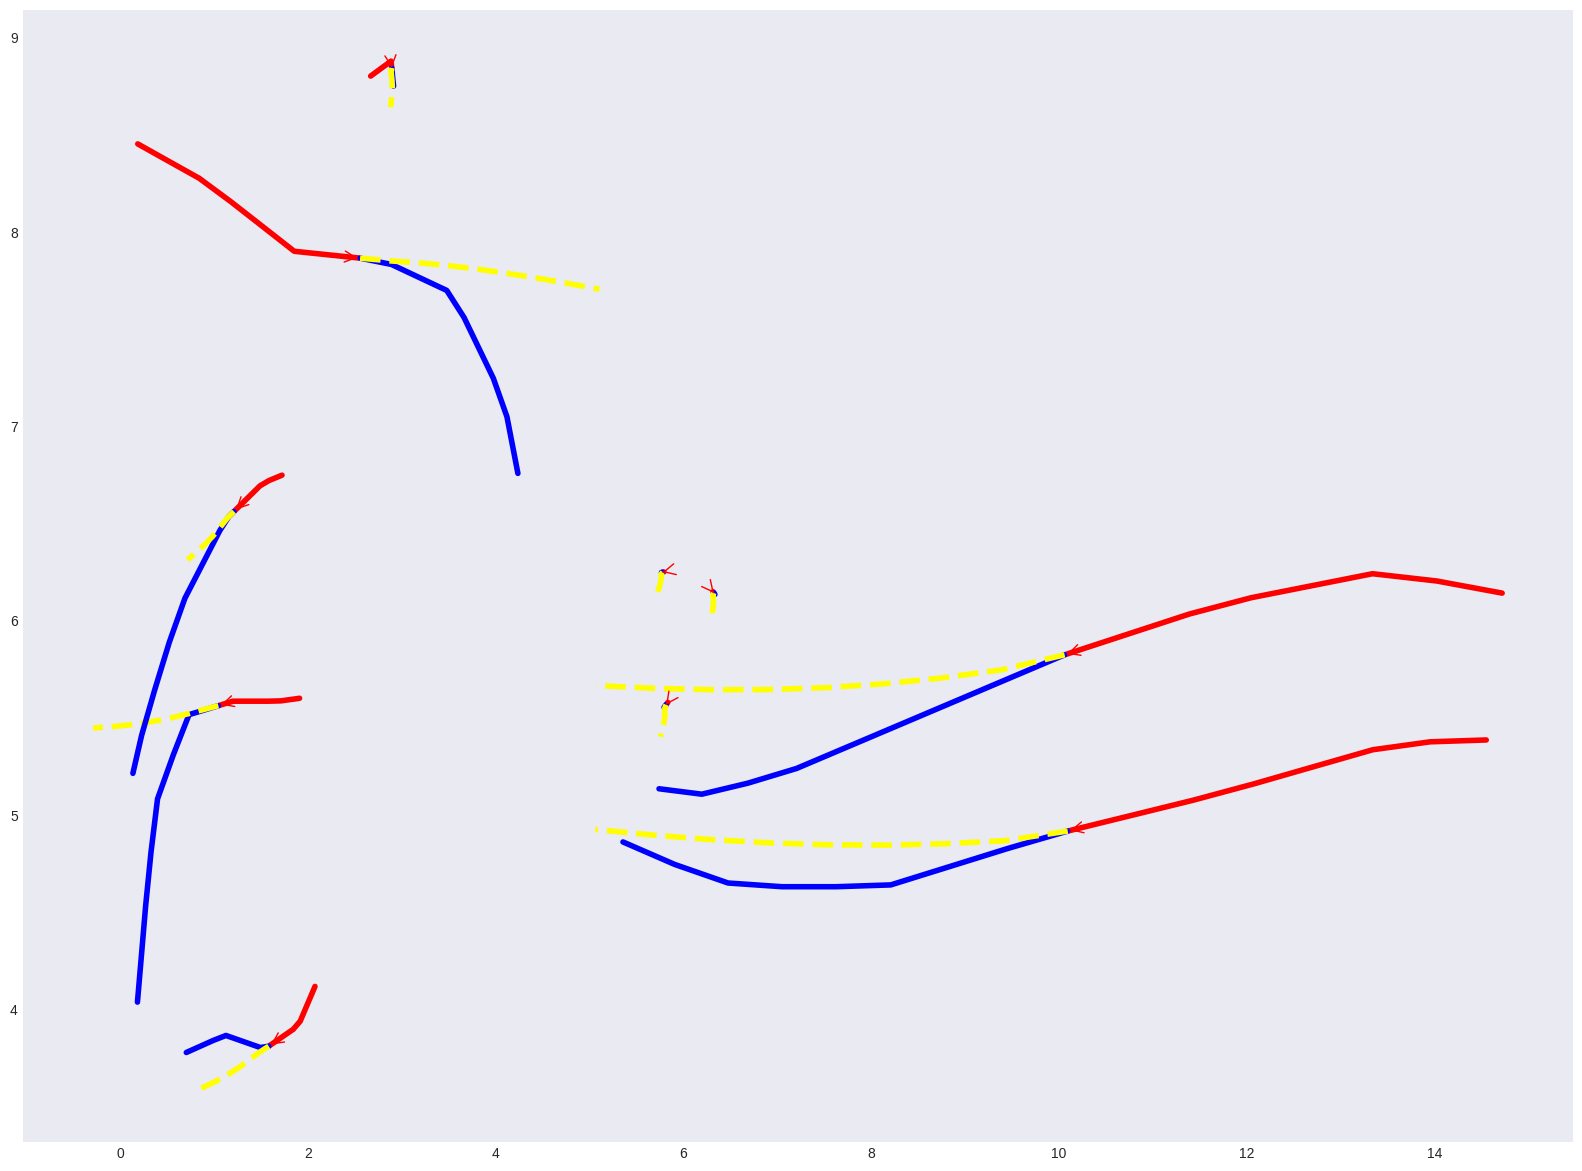

In [21]:

import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.style.use("seaborn-dark")

args = easydict.EasyDict({
        "log_dir": "./",
        "dataset_name": "zara2",
        "delim": "\t",
        "loader_num_workers": 1,  #原:4
        "obs_len": 8,
        
        "skip": 1,
        "seed": 72,
        "batch_size":64,
        
        "noise_dim":(16,),
        "noise_type":"gaussian",
        "noise_mix_type": "global",

        "traj_lstm_input_size":2,
        "traj_lstm_hidden_size":32,
        "heads":"4,1",
        "hidden_units":"16",
        "graph_network_out_dims":32,
        "graph_lstm_hidden_size":32,
        "dropout":0,
        "alpha": 0.2,
        "lr":1e-3,
        "start_epoch":0,
        
        
        "use_gpu":1,
        "gpu_num":"0",
        "print_every":5,

        "resume":"checkpoint/bestK10_checkpoint295.pth.tar",

        "pred_len": 8,
        "num_samples": 20,
        "epoch_step1":150,
        "epoch_step2":250,
        "num_epochs":400,

        "dset_type":"test"
})


def evaluate_helper(error, seq_start_end, model_output_traj, model_output_traj_best):
    error = torch.stack(error, dim=1)
    for (start, end) in seq_start_end:
        start = start.item()
        end = end.item()
        _error = error[start:end]
        _error = torch.sum(_error, dim=0)
        min_index = _error.min(0)[1].item()
        model_output_traj_best[:, start:end, :] = model_output_traj[min_index][
            :, start:end, :
        ]
    return model_output_traj_best


def get_generator(checkpoint):
    n_units = (
        [args.traj_lstm_hidden_size]
        + [int(x) for x in args.hidden_units.strip().split(",")]
        + [args.graph_lstm_hidden_size]
    )
    n_heads = [int(x) for x in args.heads.strip().split(",")]
    model = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        traj_lstm_input_size=args.traj_lstm_input_size,
        traj_lstm_hidden_size=args.traj_lstm_hidden_size,
        n_units=n_units,
        n_heads=n_heads,
        graph_network_out_dims=args.graph_network_out_dims,
        dropout=args.dropout,
        alpha=args.alpha,
        graph_lstm_hidden_size=args.graph_lstm_hidden_size,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
    )
    model.load_state_dict(checkpoint["state_dict"])
    model.cuda()
    model.eval()
    return model


def cal_ade_fde(pred_traj_gt, pred_traj_fake):
    ade = displacement_error(pred_traj_fake, pred_traj_gt, mode="raw")
    fde = final_displacement_error(pred_traj_fake[-1], pred_traj_gt[-1], mode="raw")
    return ade, fde


def plot_trajectory(args, loader, generator):
    ground_truth_input = []
    all_model_output_traj = []
    ground_truth_output = []
    pic_cnt = 0
    with torch.no_grad():
        for batch in loader:
            batch = [tensor.cuda() for tensor in batch]
            (
                obs_traj,
                pred_traj_gt,
                obs_traj_rel,
                pred_traj_gt_rel,
                non_linear_ped,
                loss_mask,
                seq_start_end,
            ) = batch
            ade = []
            ground_truth_input.append(obs_traj)
            ground_truth_output.append(pred_traj_gt)
            model_output_traj = []
            model_output_traj_best = torch.ones_like(pred_traj_gt).cuda()

            for _ in range(args.num_samples):
                pred_traj_fake_rel = generator(
                    obs_traj_rel, obs_traj, seq_start_end, 0, 3
                )
                pred_traj_fake_rel = pred_traj_fake_rel[-args.pred_len :]

                pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])
                model_output_traj.append(pred_traj_fake)
                ade_, fde_ = cal_ade_fde(pred_traj_gt, pred_traj_fake)
                ade.append(ade_)
            model_output_traj_best = evaluate_helper(
                ade, seq_start_end, model_output_traj, model_output_traj_best
            )
            all_model_output_traj.append(model_output_traj_best)

            for (start, end) in seq_start_end:
                plt.figure(figsize=(20,15), dpi=100)
                ground_truth_input_x_piccoor = (
                    obs_traj[:, start:end, :].cpu().numpy()[:, :, 0].T
                )
                ground_truth_input_y_piccoor = (
                    obs_traj[:, start:end, :].cpu().numpy()[:, :, 1].T
                )
                ground_truth_output_x_piccoor = (
                    pred_traj_gt[:, start:end, :].cpu().numpy()[:, :, 0].T
                )
                ground_truth_output_y_piccoor = (
                    pred_traj_gt[:, start:end, :].cpu().numpy()[:, :, 1].T
                )
                model_output_x_piccoor = (
                    model_output_traj_best[:, start:end, :].cpu().numpy()[:, :, 0].T
                )
                model_output_y_piccoor = (
                    model_output_traj_best[:, start:end, :].cpu().numpy()[:, :, 1].T
                )
                for i in range(ground_truth_output_x_piccoor.shape[0]):

                    observed_line = plt.plot(
                        ground_truth_input_x_piccoor[i, :],
                        ground_truth_input_y_piccoor[i, :],
                        "r-",
                        linewidth=4,
                        label="Observed Trajectory",
                    )[0]
                    observed_line.axes.annotate(
                        "",
                        xytext=(
                            ground_truth_input_x_piccoor[i, -2],
                            ground_truth_input_y_piccoor[i, -2],
                        ),
                        xy=(
                            ground_truth_input_x_piccoor[i, -1],
                            ground_truth_input_y_piccoor[i, -1],
                        ),
                        arrowprops=dict(
                            arrowstyle="->", color=observed_line.get_color(), lw=1
                        ),
                        size=20,
                    )
                    ground_line = plt.plot(
                        np.append(
                            ground_truth_input_x_piccoor[i, -1],
                            ground_truth_output_x_piccoor[i, :],
                        ),
                        np.append(
                            ground_truth_input_y_piccoor[i, -1],
                            ground_truth_output_y_piccoor[i, :],
                        ),
                        "b-",
                        linewidth=4,
                        label="Ground Truth",
                    )[0]
                    predict_line = plt.plot(
                        np.append(
                            ground_truth_input_x_piccoor[i, -1],
                            model_output_x_piccoor[i, :],
                        ),
                        np.append(
                            ground_truth_input_y_piccoor[i, -1],
                            model_output_y_piccoor[i, :],
                        ),
                        color="#ffff00",
                        ls="--",
                        linewidth=4,
                        label="Predicted Trajectory",
                    )[0]

                #plt.axis("off")
                plt.savefig(
                    "./traj_fig/pic_{}.png".format(pic_cnt)
                )
                plt.close()
                pic_cnt += 1


def main(args):
    checkpoint = torch.load(args.resume)
    generator = get_generator(checkpoint)
    path = get_dset_path(args.dataset_name, args.dset_type)

    _, loader = data_loader(args, path)
    plot_trajectory(args, loader, generator)


if __name__ == "__main__":
    #args = parser.parse_args()
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.mkdir("./traj_fig")
    main(args)

## Attention Multiply Example

In [ ]:
import torch

w = torch.Tensor([
                [6,3],
                [5,2],
                [4,1]
                ])
print('w:',w)
A = torch.Tensor([1,2,3,4])
print('a^T:',A)
def cal(h_src, h_dst):
 
  Wh_front = torch.matmul(h_src, w)
  Wh_back = torch.matmul(h_dst, w)
  Concat = torch.cat([Wh_front, Wh_back], dim=0)
  print('Wh_front:',Wh_front,', Wh_back:',Wh_back,', Concat:', Concat)
  return torch.matmul(Concat, A)

h = torch.Tensor([[1,2,3],
                  [4,5,6],
                  [7,8,9]
                  ])
print(h)
print(h.size())

a11 = cal(h[0], h[0])
print('a11:',a11)

a12 = cal(h[0], h[1])
print('a12:',a12)

a21 = cal(h[1], h[0])
print('a21:',a21)
print('----------')

n = h.size()[1]  
h_prime = torch.matmul(h, w)  
print('h_prime:',h_prime)

# F_out x 1
a_src = torch.Tensor([[1],
                      [2]
                      ])
a_dst = torch.Tensor([[3],
                      [4]
                      ])

attn_src = torch.matmul(h_prime, a_src)    # bs x n_head x n x 1
attn_dst = torch.matmul(h_prime, a_dst)    # bs x n_head x n x 1
print('attn_src:',attn_src)
print('attn_dst:',attn_dst)

print('attn_src.expand:',attn_src.expand(-1, n))
print('attn_dst.expand:',attn_dst.expand(-1, n))
print('permute', attn_dst.expand(-1, n).permute(1,0) )
attn = attn_src.expand(-1, n) + attn_dst.expand(-1, n).permute(
            1,0
        ) # bs x n_head x n x n
print('attn:',attn )

In [3]:
import torch 
import numpy as np

A = torch.tensor([
    [0., 1., 0., 0.],
    [0., 0., 1., 1.], 
    [0., 1., 0., 0.],
    [1., 0., 1., 0.]]
)
print(A)

D = torch.tensor([
    [1., 0., 0., 0.],
    [0., 2., 0., 0.], 
    [0., 0., 2., 0.],
    [0., 0., 0., 1.]]
)

print(D**-1)

print(torch.matmul(A, D**-1, ))





tensor([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])
tensor([[1.0000,    inf,    inf,    inf],
        [   inf, 0.5000,    inf,    inf],
        [   inf,    inf, 0.5000,    inf],
        [   inf,    inf,    inf, 1.0000]])
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]])
